In [17]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm


from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config
from gpudrive.utils.checkpoint import load_policy
from gpudrive.utils.rollout import rollout

from PIL import Image

In [2]:
# Configs model has been trained with
config = load_config("/home/emerge/gpudrive/baselines/ppo/config/ppo_base_puffer")

print(config)

num_envs = 4
device = "cpu"
max_agents = 64

config.environment.reward_type = "reward_conditioned"
config.environment.condition_mode = "fixed"
config.environment.agent_type = torch.Tensor([-0.2, 1.0, -0.2])

{'mode': 'train', 'use_rnn': False, 'eval_model_path': None, 'baseline': False, 'data_dir': 'data/processed/training', 'continue_training': False, 'model_cpt': None, 'environment': {'name': 'gpudrive', 'num_worlds': 50, 'k_unique_scenes': 50, 'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': False, 'lidar_obs': False, 'reward_type': 'reward_conditioned', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'init_mode': 'all_non_trivial', 'condition_mode': 'random', 'collision_weight_lb': -3.0, 'collision_weight_ub': 0.01, 'goal_achieved_weight_lb': 1.0, 'goal_achieved_weight_ub': 3.0, 'off_road_weight_lb': -3.0, 'off_road_weight_ub': 0.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'use_vbd': 

In [3]:
agent = load_policy(
    model_name="rew_conditioned_0321",
    path_to_cpt="/home/emerge/gpudrive/examples/experimental/models",
    env_config=config.environment,
    device=device
);

Load model from /home/emerge/gpudrive/examples/experimental/models/rew_conditioned_0321.pt


In [4]:
# Create data loader
train_loader = SceneDataLoader(
    root='/home/emerge/gpudrive/data/processed/examples/',
    batch_size=num_envs,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
config = config.environment
env_config = dataclasses.replace(
    EnvConfig(),
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
    reward_type=config.reward_type,
    condition_mode=config.condition_mode,
    agent_type=config.agent_type,
)

# Make env
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=1, #config.max_controlled_agents,
    device=device,
)

In [5]:
def run_multiple_rollouts(
    env, 
    agent, 
    num_rollouts=2, 
    device='cpu',
    sample_collision_weights=True,
    sample_goal_weights=False,
    sample_offroad_weights=False,
    agent_type=None,
):
    """
    Run multiple rollouts with different collision weights and store trajectories.
    Stores agent positions as a tensor of shape [num_envs, num_rollouts, agents, steps, 2].
    
    Args:
        env: The environment (can be batched with multiple environments)
        agent: The policy
        num_rollouts: Number of rollouts to perform
        device: Device to run on
        
    Returns:
        all_trajectories: Dictionary containing trajectories and weights
    """
    
    all_agent_positions = []
    collision_weights = []
    goal_weights = []
    offroad_weights = []
    all_goal_achieved = []
    all_collided = []
    all_off_road = []
    all_episode_lengths = []
    
    print(f"Running {num_rollouts} rollouts, sampling weights: collision={sample_collision_weights}, goal={sample_goal_weights}, offroad={sample_offroad_weights}\n")
    
    for i in tqdm(range(num_rollouts), desc="Processing rollouts", unit="rollout"):
        
        # Sample weights
        if agent_type is not None:
            agent_weights = agent_type
            collision_weight = agent_weights[0].item()
            goal_weight = agent_weights[1].item()
            off_road_weight = agent_weights[2].item()
        else:
            if sample_collision_weights:
                collision_weight = random.uniform(-3.0, 1.0)
            else:
                collision_weight = -3.0
            if sample_goal_weights:
                goal_weight = random.uniform(1.0, 3.0)
            else:
                goal_weight = 1.0
            if sample_offroad_weights:
                off_road_weight = random.uniform(-3.0, 1.0)
            else:
                off_road_weight = -3.0

            agent_weights = torch.Tensor([collision_weight, goal_weight, off_road_weight])
        
        # Run rollout with these weights
        (
            goal_achieved_count,
            frac_goal_achieved,
            collided_count,
            frac_collided,
            off_road_count,
            frac_off_road,
            not_goal_nor_crash_count,
            frac_not_goal_nor_crash_per_scene,
            controlled_agents_per_scene,
            sim_state_frames,
            agent_positions,
            episode_lengths
        ) = rollout(
            env=env,
            policy=agent,
            device=device,
            deterministic=False,
            return_agent_positions=True,
            set_agent_type=True,
            agent_weights=agent_weights,
        )
        
        # Store weights and positions
        collision_weights.append(collision_weight)
        goal_weights.append(goal_weight)
        offroad_weights.append(off_road_weight)
        all_agent_positions.append(agent_positions.clone().detach())
        
        # Store other metrics
        all_goal_achieved.append(goal_achieved_count)
        all_collided.append(collided_count)
        all_off_road.append(off_road_count)
        all_episode_lengths.append(episode_lengths)
    
    # Stack agent positions along a new dimension at position 1 (after num_envs)
    # From list of [num_envs, num_agents, time_steps, 2] to tensor of [num_envs, num_rollouts, num_agents, time_steps, 2]
    stacked_positions = torch.stack(all_agent_positions, dim=1)
    
    # Return organized data
    all_trajectories = {
        'collision_weights': torch.tensor(collision_weights),
        'goal_weights': torch.tensor(goal_weights),
        'offroad_weights': torch.tensor(offroad_weights),
        'agent_positions': stacked_positions,  # Shape: [num_envs, num_rollouts, num_agents, time_steps, 2]
        'goal_achieved': all_goal_achieved,
        'collided': all_collided,
        'off_road': all_off_road,
        'episode_lengths': all_episode_lengths
    }
    
    return all_trajectories

In [6]:
# Define different agent types to compare
agent_configs = { # Collision, Goal, Off-road
    'Nominal': torch.tensor([-0.75, 1.0, -0.75], device=device),
    'Aggressive': torch.tensor([0.0, 2.0, 0.0], device=device),
    'Risk-averse': torch.tensor([-2.0, 0.5, -2.0], device=device),
}

In [10]:
trajs = run_multiple_rollouts(
    env=env,
    agent=agent,
    num_rollouts=50,
    device='cpu',
    sample_collision_weights=True,
    sample_goal_weights=False,
    sample_offroad_weights=False,
    #agent_type=agent_configs['Risk-averse'],
);

Running 50 rollouts, sampling weights: collision=True, goal=False, offroad=False



Processing rollouts: 100%|██████████| 50/50 [01:25<00:00,  1.70s/rollout]


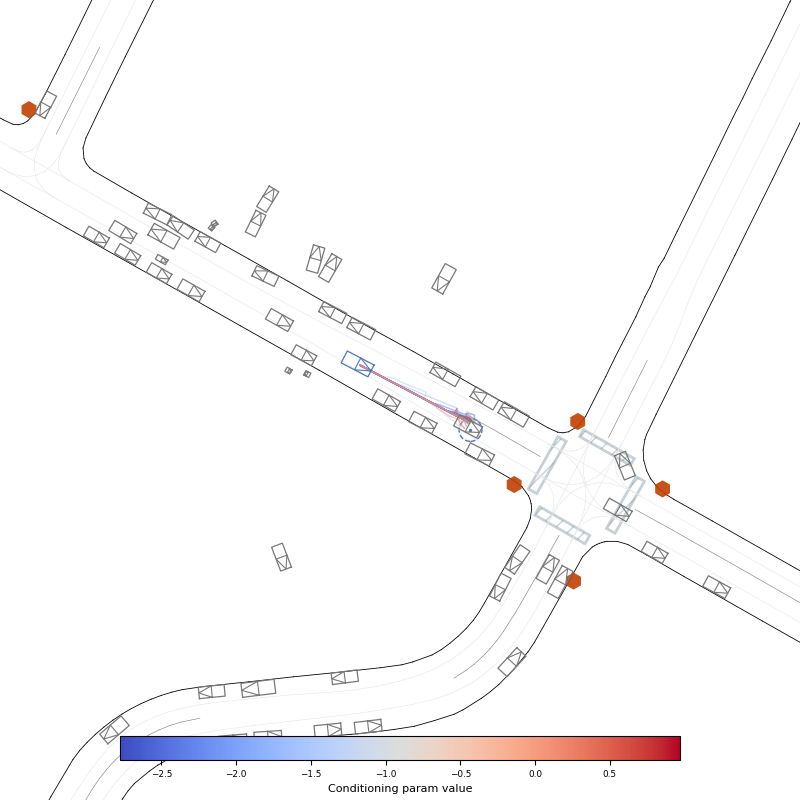

In [12]:
env.vis.figsize = (8, 8)

# Plot simulator state with the stacked trajectories
_ = env.reset(agent_type=torch.Tensor([-0.2, 1.0, -0.2]))
img = env.vis.plot_simulator_state(
    env_indices=[1], 
    agent_positions=trajs['agent_positions'],  # Pass stacked trajectories directly
    zoom_radius=70,
    multiple_rollouts=True,
    line_alpha=0.5,          
    line_width=1.0,     
    weights=trajs['collision_weights'],     
    colorbar=True, 
)[0]

Image.fromarray(img_from_fig(img))

In [9]:
fig = img  
filename = "effect_of_rew_cond.png"
fig.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(f"Figure saved as {filename}")

Figure saved as effect_of_rew_cond.png


### Analyze diversity

In [14]:
agent_configs = {
    'Nominal': torch.tensor([-0.5, 0.1, -0.5], device=device),
}

print("Collecting rollout data...")
collected_data = {}

agent_weights = torch.Tensor([-0.2, 1.0, -0.2])


div_metrics = collect_rollout_data(
    env, agent, agent_weights, device, 2
)

#df = store_data_to_dataframe(list(agent_configs.keys()), collected_data)


  Rollout 1/2
  Rollout 2/2


In [16]:
div_metrics.keys()

dict_keys(['situation_responses', 'entropy_values', 'logprob_values'])

In [18]:
div_metrics['entropy_values'].shape

torch.Size([5, 64, 91])

### Effect on human-replay interaction

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the styling
sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
# Prepare the data for the plots
agents = ['Self-play', 'Population play']

# Data for the first plot: controlling all agents
all_agents_rates = [0.5, 2.85]
all_agents_df = pd.DataFrame({
    'Agent': agents,
    'Collision Rate (%)': all_agents_rates
})

# Data for the second plot: controlling single agent
single_agent_rates = [6.0, 9.50]
single_agent_df = pd.DataFrame({
    'Agent': agents,
    'Collision Rate (%)': single_agent_rates
})

# Calculate relative increase as multiples (times increase) for the third plot
relative_increases = []
for i in range(len(agents)):
    # Formula for X times increase: new_value / old_value
    times_increase = single_agent_rates[i] / all_agents_rates[i]
    relative_increases.append(times_increase)

relative_df = pd.DataFrame({
    'Agent': agents,
    'Performance drop SP -> Human': relative_increases
})

# Create 1x3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Collision rates controlling all agents
sns.barplot(x='Agent', y='Collision Rate (%)', hue='Agent', data=all_agents_df, 
           palette='muted', legend=False, ax=axs[0])
axs[0].set_title('Controlling All Agents')
axs[0].set_ylim(0, max(all_agents_rates) * 1.2)  # Add some space above bars
for i, v in enumerate(all_agents_rates):
    axs[0].text(i, v + 0.1, f"{v}%", ha='center')

# Plot 2: Collision rates controlling single agent
sns.barplot(x='Agent', y='Collision Rate (%)', hue='Agent', data=single_agent_df, 
           palette='pastel', legend=False, ax=axs[1])
axs[1].set_title('Control Single Agent \n with Human Replays')
axs[1].set_ylim(0, max(single_agent_rates) * 1.2)  # Add some space above bars
for i, v in enumerate(single_agent_rates):
    axs[1].text(i, v + 0.3, f"{v}%", ha='center')

# Plot 3: Times increase
sns.barplot(x='Agent', y='Performance drop SP -> Human', hue='Agent', data=relative_df, 
           palette='dark', legend=False, ax=axs[2])
axs[2].set_title('Rel. Increase in Collision Rates \n (X times)', y=1.05)
for i, v in enumerate(relative_increases):
    axs[2].text(i, v + 0.3, f"{v:.1f}x", ha='center')

# Add annotation about risk averse agents
fig.text(0.5, 0.01, 
         "Note: The Population play agent type is set to be risk averse.", 
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for annotation
sns.despine()
plt.savefig('collision_rates_comparison.png', dpi=300)

plt.show()